# Model

In [12]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import warnings
from sklearn.tree import export_text
from sklearn.feature_selection import RFE
%matplotlib inline
warnings.filterwarnings(action='once')
sns.set_theme(style="darkgrid")

In [14]:
# Read in the data from preprocessing and feature engineering
result_df = pd.read_csv('Data/Modeling_v1.csv')
result_df.drop(columns=['Unnamed: 0'], inplace=True)
result_df.top_3 = result_df.top_3.astype('int')

In [16]:
# Checking What columns we have
result_df.columns

Index(['driverId', 'grid', 'positionOrder', 'points', 'statusId', 'year',
       'round', 'circuitId', 'top_3', 'top_3_label',
       'top3_driver_season_percentage', 'driver_avg_finish_pos_season',
       'Constructor_Top3_Percent', 'Top_3_at_circuit', 'round_max_last_szn',
       'top3_driver_season_percentage_lag', 'driver_avg_finish_pos_season_lag',
       'Constructor_Top3_Percent_lag', 'round_lag'],
      dtype='object')

In [18]:
# getting info about the numerical data in the data set
result_df[['top_3', 'grid', 'top3_driver_season_percentage', 'Constructor_Top3_Percent', 'driver_avg_finish_pos_season', 'Top_3_at_circuit']].describe().T

,count,mean,std,min,25%,50%,75%,max
top_3,25967.0,0.126699,0.332642,0.0,0.000000,0.000000,0.000000,1.0
grid,25967.0,11.149806,7.230978,0.0,5.000000,11.000000,17.000000,34.0
top3_driver_season_percentage,25967.0,11.529197,22.828811,0.0,0.000000,0.000000,12.500000,100.0
Constructor_Top3_Percent,25967.0,11.841106,19.583740,0.0,0.000000,0.000000,16.904762,100.0
driver_avg_finish_pos_season,25967.0,11.544304,5.405081,0.0,9.121212,11.503876,14.563333,39.0
Top_3_at_circuit,25967.0,5.119997,11.214859,0.0,0.000000,0.000000,0.000000,87.5


In [20]:
print(f'class 1: {result_df[result_df.top_3 == True].top_3.count() / result_df.shape[0]:.2%}')

class 1: 12.67%


We have an imbalanced dataset

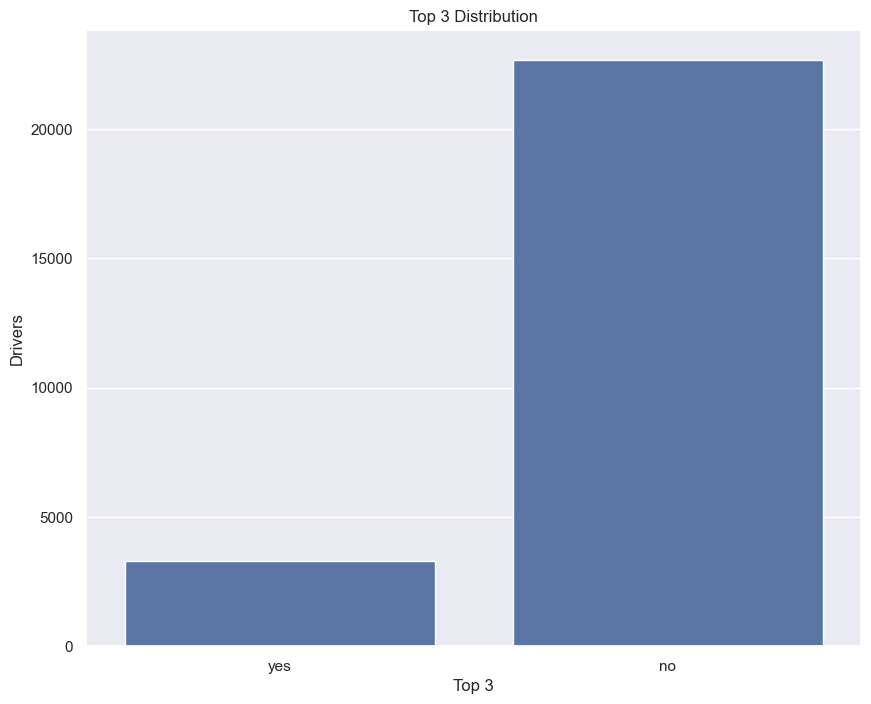

In [22]:
# Distribution of the target which is positionOrder
fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(data=result_df, x='top_3_label', ax=ax)
ax.set_title('Top 3 Distribution')
ax.set_xlabel('Top 3')
ax.set_ylabel('Drivers')
plt.savefig('Images/TargetDistribution.png')
plt.show()

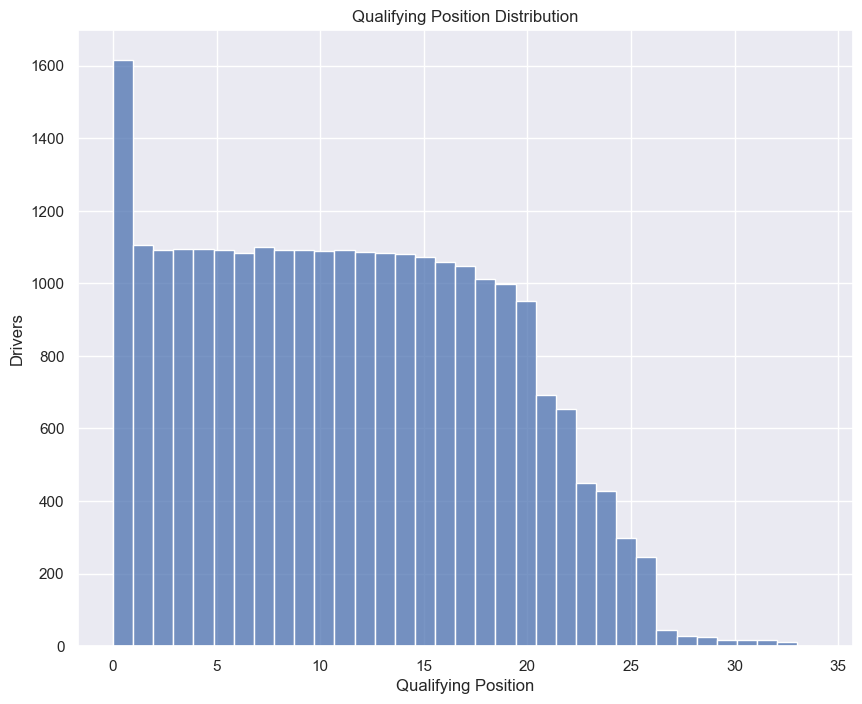

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=result_df, x='grid',bins=35, ax=ax)
ax.set_title('Qualifying Position Distribution')
ax.set_xlabel('Qualifying Position')
ax.set_ylabel('Drivers')
plt.savefig(f'Images/GridDistribution.png')
plt.show()

Normal distribution, as expected trailing off near the end because some season had many more drivers

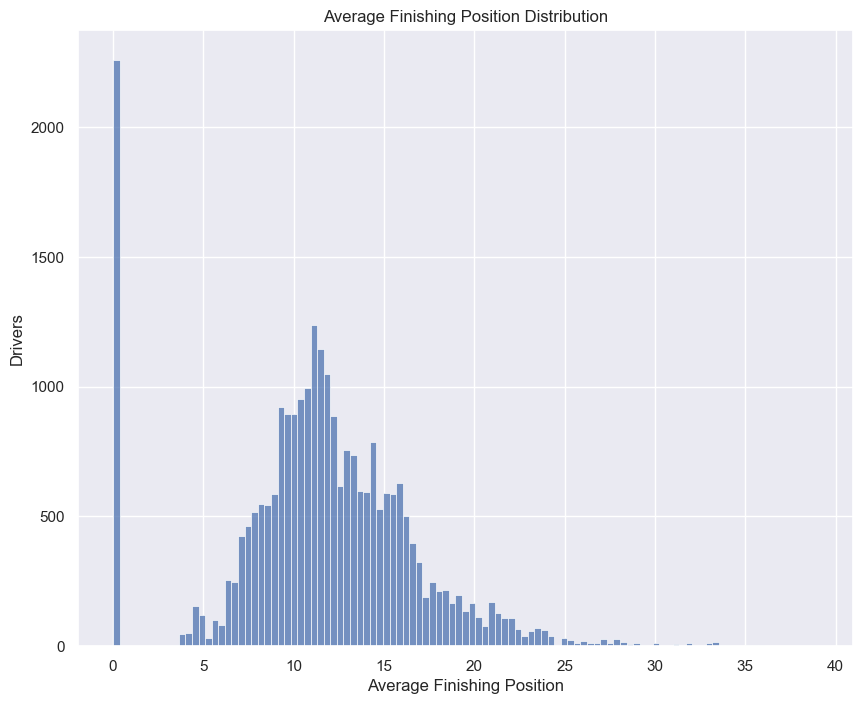

In [26]:
# Getting Distribution Plots
features = ['driver_avg_finish_pos_season', 'top3_driver_season_percentage', 'driver_avg_finish_pos_season_lag', 'top3_driver_season_percentage_lag', 'Constructor_Top3_Percent', 'Top_3_at_circuit']
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=result_df, x='driver_avg_finish_pos_season')
ax.set_title('Average Finishing Position Distribution')
ax.set_xlabel('Average Finishing Position')
ax.set_ylabel('Drivers')
plt.savefig('Images/driver_avg_finish_pos_seasonDistribution.png')
plt.show()

Normal distribution, this is what is expected after a season certain people will fall above or below the middle position but most will be right around there for their average finishing position

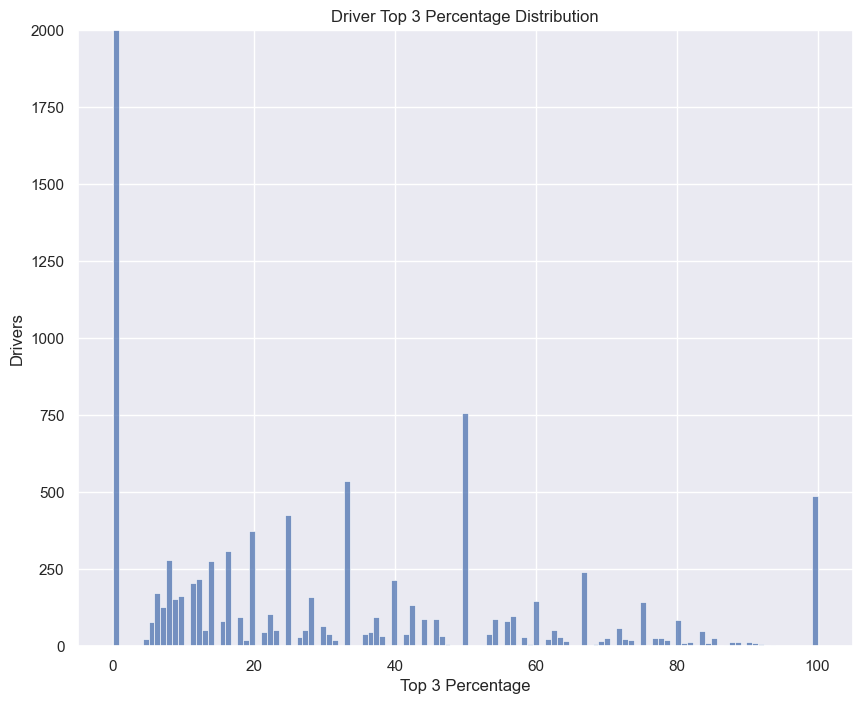

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=result_df, x='top3_driver_season_percentage')
ax.set_title('Driver Top 3 Percentage Distribution')
ax.set_xlabel('Top 3 Percentage')
ax.set_ylabel('Drivers')
ax.set_ylim(top=2000)
plt.savefig('Images/top3_driver_season_percentageDistribution.png')
plt.show()

Most people would not finish in the top 3 in a season and most of the people who do will only finish in the top 3 a few times except for an elite few

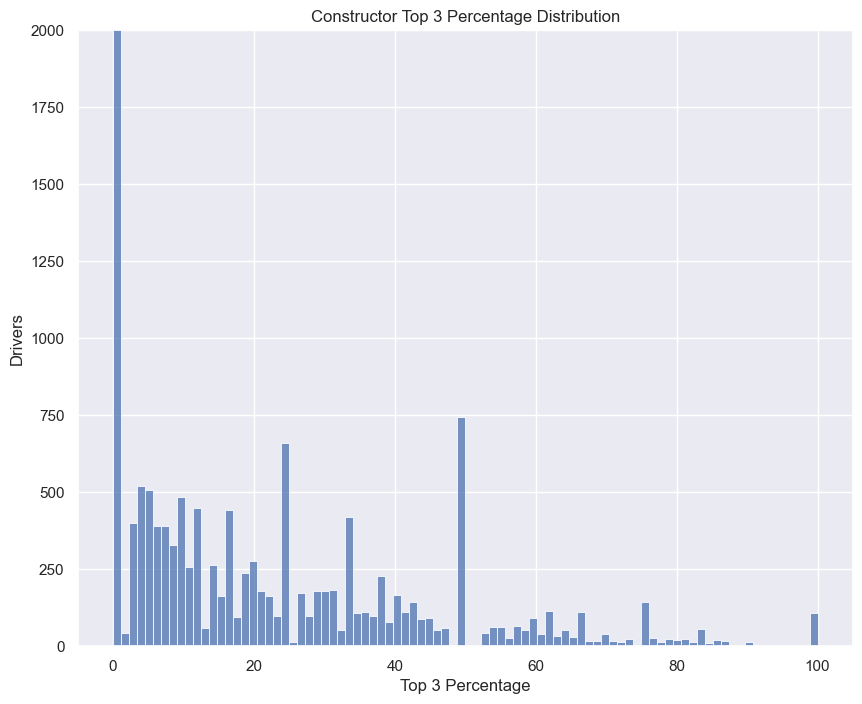

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=result_df, x='Constructor_Top3_Percent')
ax.set_title('Constructor Top 3 Percentage Distribution')
ax.set_xlabel('Top 3 Percentage')
ax.set_ylabel('Drivers')
ax.set_ylim(top=2000)
plt.savefig('Images/Constructor_Top3_PercentDistribution.png')
plt.show()

Provides same insight as above except for teams only a few teams will finish in the top 3 and they will only do it a few times a season except for an elite few

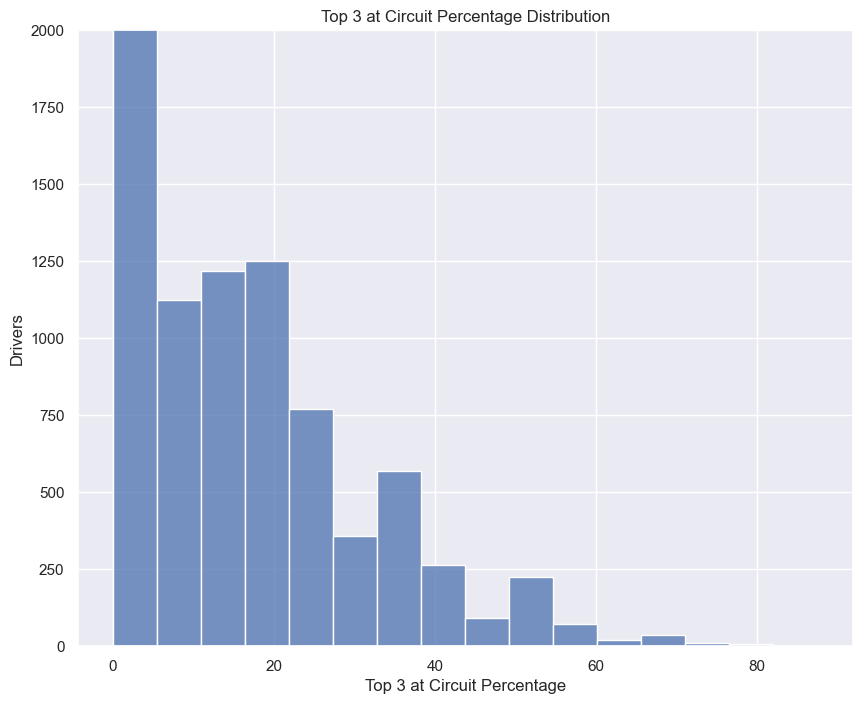

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=result_df, x='Top_3_at_circuit')
ax.set_title('Top 3 at Circuit Percentage Distribution')
ax.set_xlabel('Top 3 at Circuit Percentage')
ax.set_ylabel('Drivers')
ax.set_ylim(top=2000)
plt.savefig('Images/Constructor_Top3_PercentDistribution.png')
plt.show()

Right skewed distribution, makes sense it is hard to finish in the top 3 at a circuit multiple times

### Getting general overview of relationships

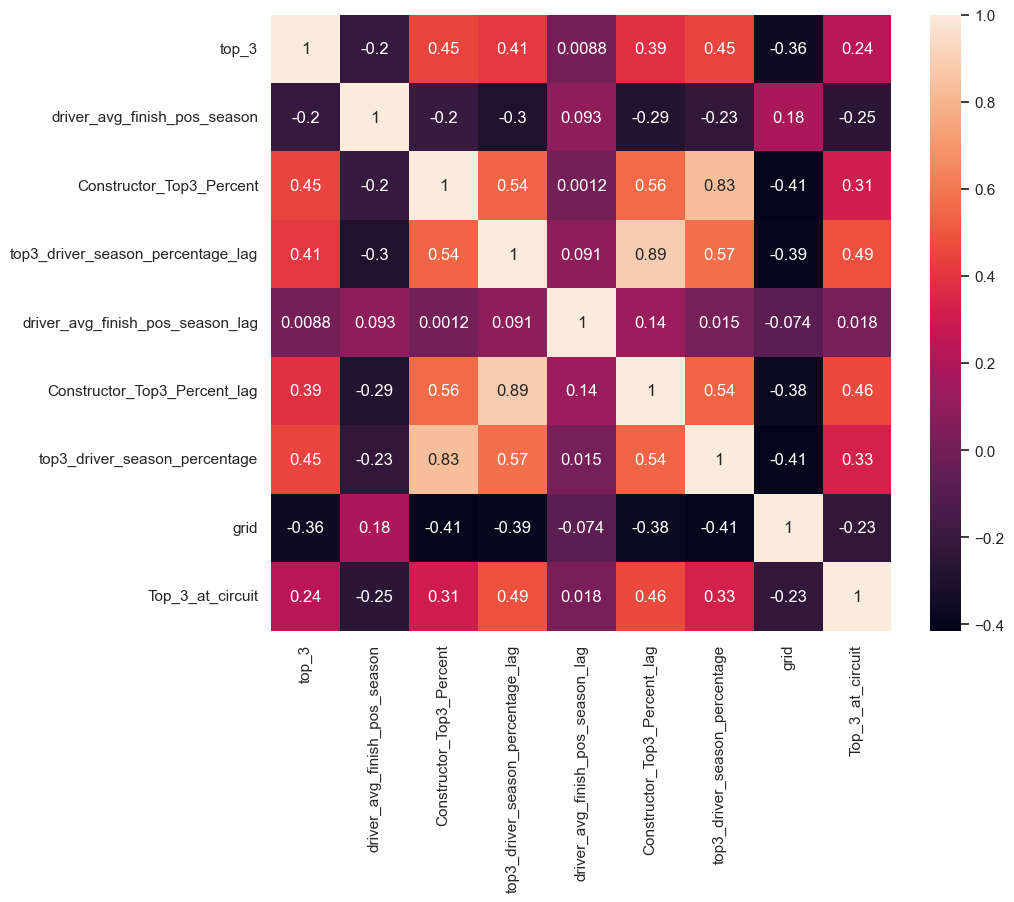

In [34]:
# making a correlation map
corr = result_df[['top_3', 'driver_avg_finish_pos_season', 'Constructor_Top3_Percent',
                  'top3_driver_season_percentage_lag', 'driver_avg_finish_pos_season_lag',
                  'Constructor_Top3_Percent_lag',
                  'top3_driver_season_percentage', 'grid', 'Top_3_at_circuit']].corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True, ax=ax)
plt.savefig('Images/CorrelationMap.png', bbox_inches="tight")
plt.show()

Some features have a good correlation with the top_3, also some collinearity happening

### Taking closer look at varaibles that are closely correlated with positionOrder

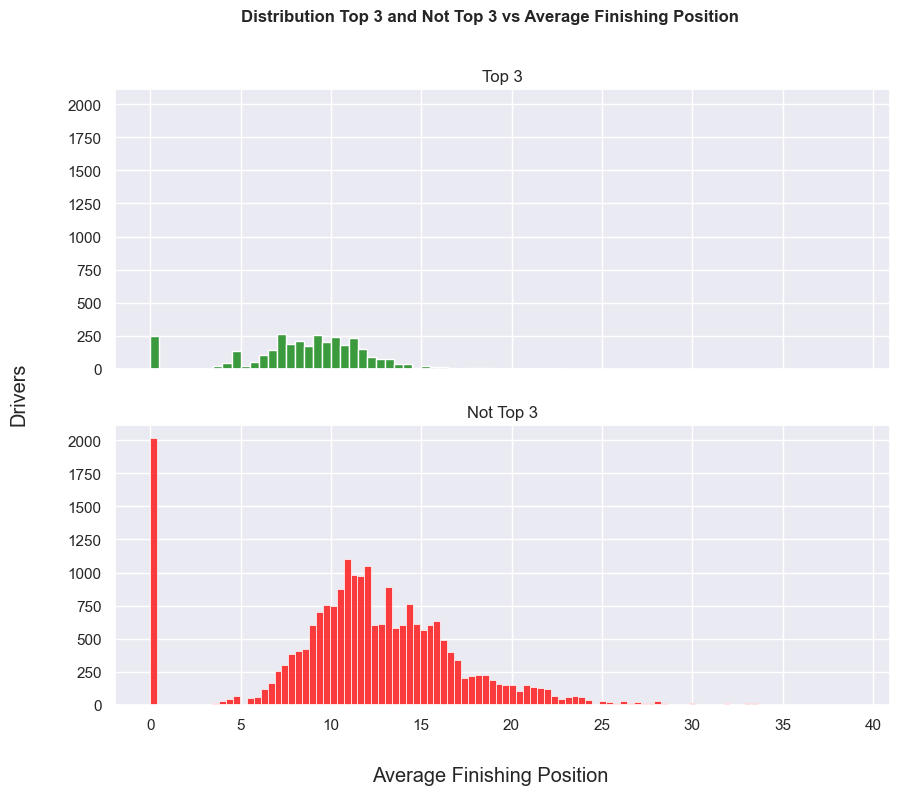

In [36]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='driver_avg_finish_pos_season', ax=ax[0], color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='driver_avg_finish_pos_season', ax=ax[1], color='red')
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Average Finishing Position', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Average Finishing Position')
plt.savefig('Images/PositionOrderVsdriver_avg_finish_pos_season.png')
plt.show()

Could be a good feature to predict top 3 as the distributions are noticably different with the mean for drivers in the top 3 being lower and the whole distribution shifted left wards compared to drivers who didn't finish in the top 3

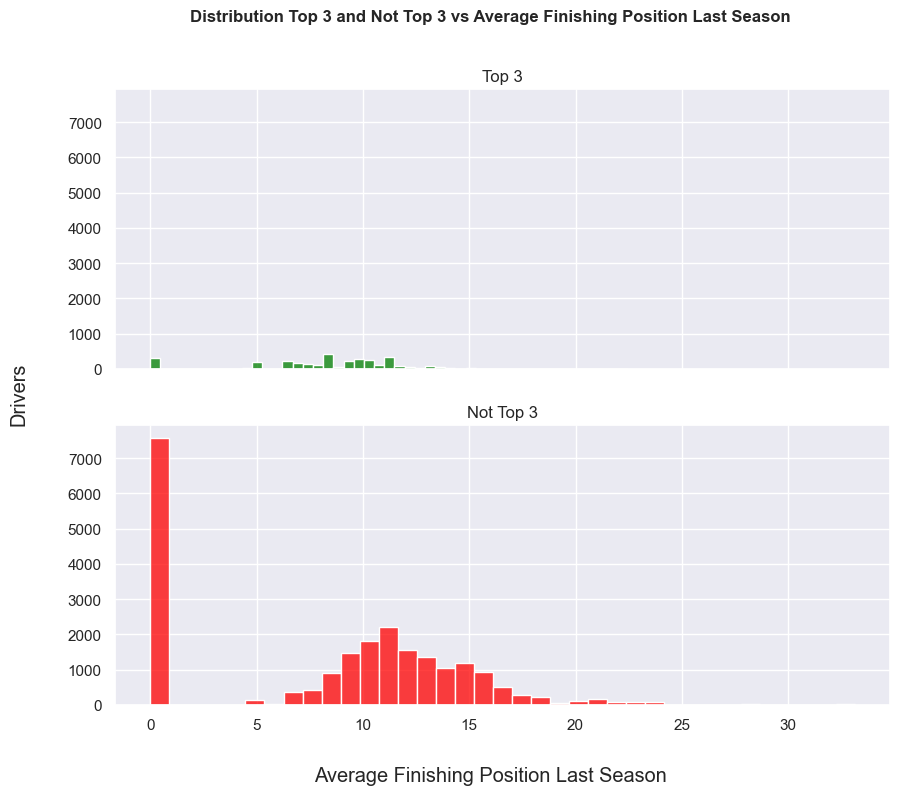

In [38]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='driver_avg_finish_pos_season_lag', ax=ax[0], color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='driver_avg_finish_pos_season_lag', ax=ax[1], color='red')
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Average Finishing Position Last Season', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Average Finishing Position Last Season')
plt.savefig('Images/driver_avg_pos_season_lag.png')
plt.show()

Could be a good predictor as the distributions are different

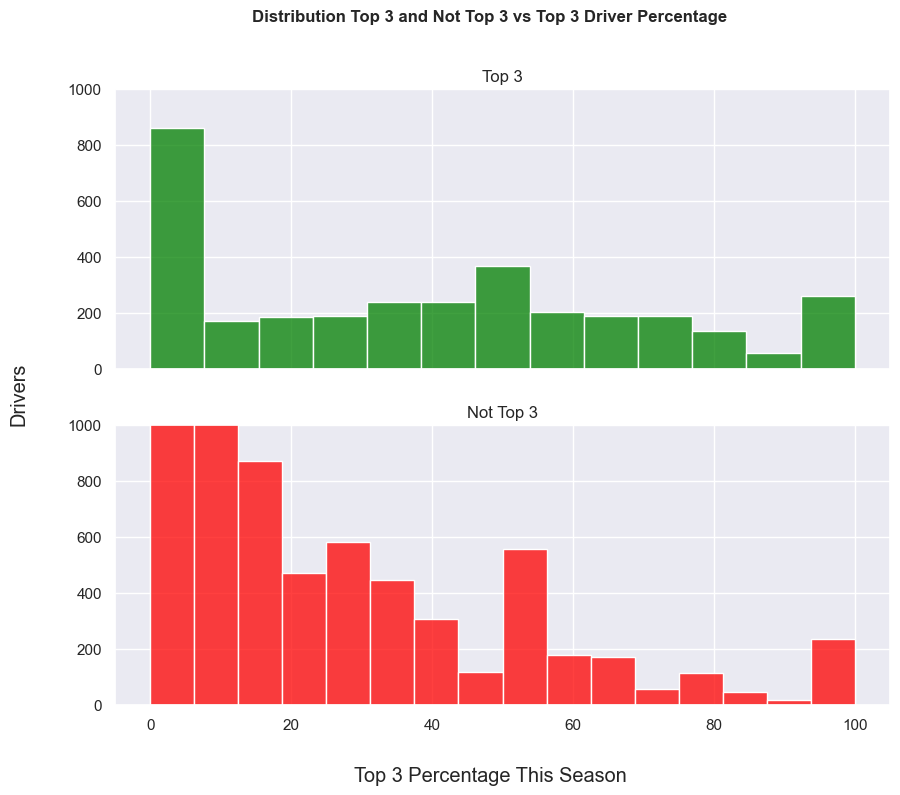

In [40]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='top3_driver_season_percentage', ax=ax[0], color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='top3_driver_season_percentage', ax=ax[1], color='red')
ax[1].set_ylim(top=1000)
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Top 3 Driver Percentage', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Top 3 Percentage This Season')
plt.savefig('Images/top3_driver_season_percentage.png')
plt.show()

Could be a good predictor as the distributions are very different 

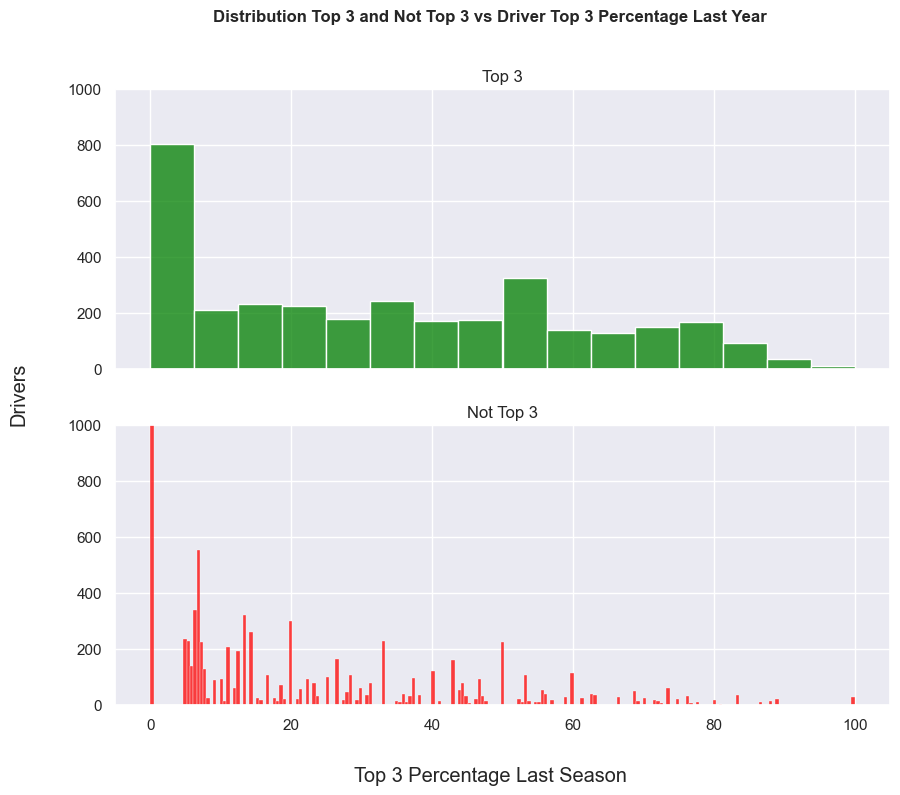

In [42]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='top3_driver_season_percentage_lag', ax=ax[0], color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='top3_driver_season_percentage_lag', ax=ax[1], color='red')
ax[1].set_ylim(top=1000)
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Driver Top 3 Percentage Last Year', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Top 3 Percentage Last Season')
plt.savefig('Images/top3_driver_season_percentage_lag.png')
plt.show()

Could be a good predictor as the distributions look to be slightly different

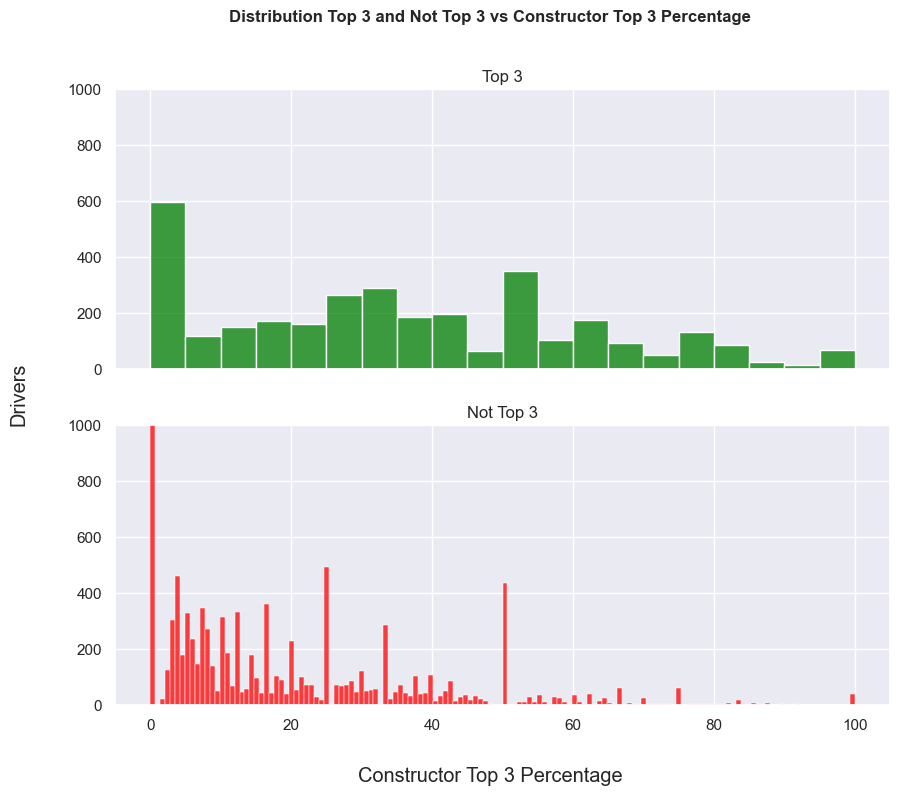

In [44]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='Constructor_Top3_Percent', ax=ax[0], color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='Constructor_Top3_Percent', ax=ax[1], color='red')
ax[1].set_ylim(top=1000)
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Constructor Top 3 Percentage', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Constructor Top 3 Percentage')
plt.savefig('Images/Constructor_Top_3Percent.png')
plt.show()

Could be a good predictor distributions look slightly different

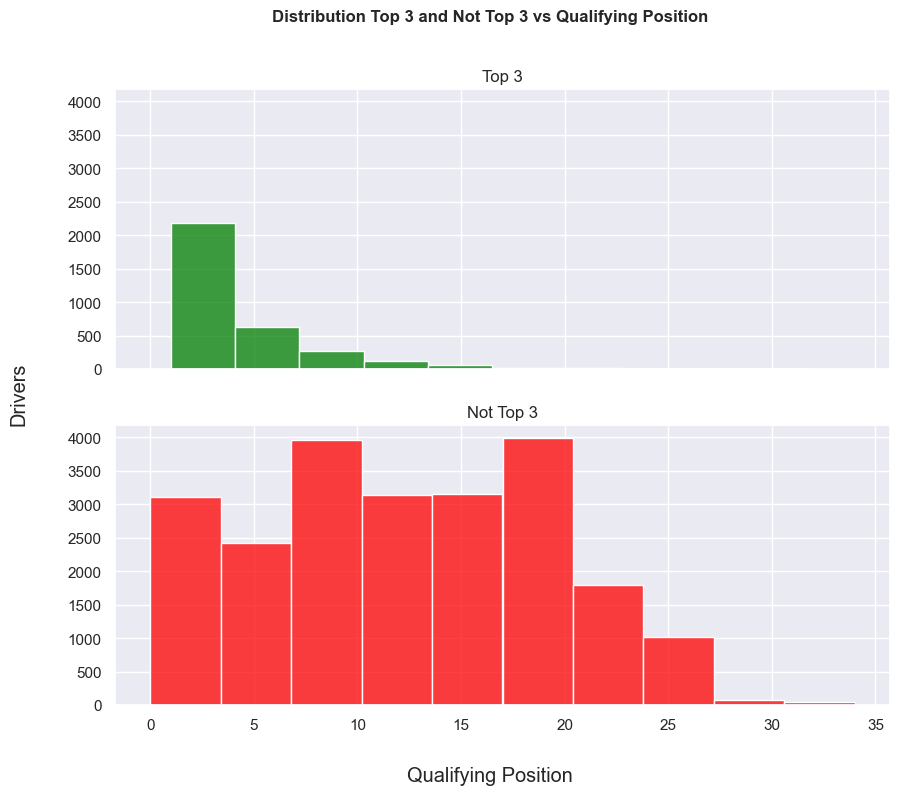

In [46]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='grid', ax=ax[0], bins=10, color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='grid', ax=ax[1], bins=10, color='red')
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Qualifying Position', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Qualifying Position')
plt.savefig('Images/grid.png')
plt.show()

Could be a very good predictor as the distributions are very different

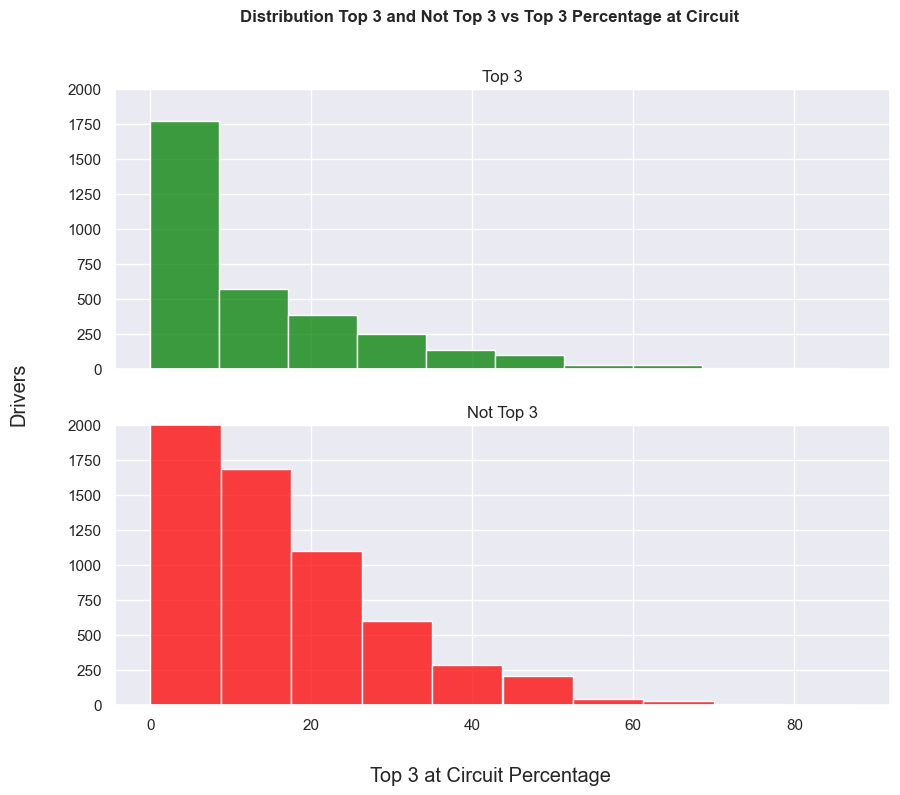

In [48]:
fig, ax = plt.subplots(figsize=(10,8), sharex=True, sharey=True, nrows=2)
sns.histplot(result_df[result_df.top_3 == 1], x='Top_3_at_circuit', ax=ax[0], bins=10, color='green')
sns.histplot(result_df[result_df.top_3 == 0], x='Top_3_at_circuit', ax=ax[1], bins=10, color='red')
ax[1].set_ylim(top=2000)
ax[0].set_title('Top 3')
ax[1].set_title('Not Top 3')
ax[1].set_ylabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
plt.suptitle('Distribution Top 3 and Not Top 3 vs Top 3 Percentage at Circuit', fontsize=12, fontweight='bold')
fig.supylabel('Drivers')
fig.supxlabel('Top 3 at Circuit Percentage')
plt.savefig('Images/top_3_at_circuit.png')
plt.show()

Could be a good predictor as the distributions are slightly different

## Modeling

In [50]:
# Splitting our data based on years to avoid data leakage
features = ['driver_avg_finish_pos_season', 'top3_driver_season_percentage', 'driver_avg_finish_pos_season_lag', 'top3_driver_season_percentage_lag', 'Constructor_Top3_Percent', 'grid', 'Top_3_at_circuit', 'Constructor_Top3_Percent_lag']
result_df.set_index(result_df['year'], inplace=True)
train = result_df['1980-01-01':'2009-01-01']
test = result_df['2010-01-01':]
train.reset_index(inplace=True, drop=True)
X_train = train[features]
X_test = test[features]
y_train = train['top_3']
y_test = test['top_3']
print(train.shape)
print(test.shape)
tss = TimeSeriesSplit(n_splits=5)  # Getting cross validation data split based off of date

(12396, 19)
(5757, 19)


In [52]:
# starting our modeling with a Decision Tree
params = {
    'criterion': ['entropy', 'log_loss', 'gini'],
    'max_depth': list(range(3,15)),
    'min_samples_split': list(range(30, 50)),
    'min_impurity_decrease':[.0001, .001, .01, .1]
}
DecisionTreeGridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, n_jobs=-1, scoring='f1', cv=tss.split(X_train, y_train), verbose=True)
DecisionTreeGridSearch.fit(X_train, y_train)
best_decision_tree = DecisionTreeGridSearch.best_estimator_

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


In [53]:
# Getting Performance metrics for the decision tree
test_prediction = best_decision_tree.predict(X_test)
test_score = roc_auc_score(y_test, test_prediction)
train_pred = best_decision_tree.predict(X_train)
# Predict probabilities for the positive class
probabilities = best_decision_tree.predict_proba(X_test)[:, 1]

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({'probabilities': probabilities, 'actual': y_test})

# Select the top 10% entries with the highest probability
top_10_percent = predictions_df.nlargest(int(len(X_test) * 0.1), 'probabilities')

# Calculate the number of actual positives in the top 10%
top_10_actual_positives = top_10_percent['actual'].sum()


# Calculate lift
lift = (top_10_actual_positives/top_10_percent.actual.count()) / (y_test.sum() / y_test.count())

print(f'Best score: {DecisionTreeGridSearch.best_score_: .2f}')
print(f'Best params: {DecisionTreeGridSearch.best_params_}')
print(f'Train roc_auc: {roc_auc_score(y_train, train_pred): .2}')
print(f'Test roc_auc: {test_score: .2}')
print(f'Train Accuracy: {best_decision_tree.score(X_train, y_train): .2%}')
print(f'Test Accuracy: {best_decision_tree.score(X_test, y_test): .2%}')
print(f'Train F1: {f1_score(y_train, train_pred): .2%}')
print(f'Test F1: {f1_score(y_test, test_prediction): .2%}')
print(f'Test recall: {recall_score(y_test, test_prediction): .2%}')
print(f'Test precision: {precision_score(y_test, test_prediction): .2%}')
print(f"Lift of the top 10%: {lift: .2}")

Best score:  0.49
Best params: {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_split': 46}
Train roc_auc:  0.71
Test roc_auc:  0.79
Train Accuracy:  90.24%
Test Accuracy:  90.13%
Train F1:  52.84%
Test F1:  64.37%
Test recall:  63.10%
Test precision:  65.69%
Lift of the top 10%:  4.8


Overall looks to be a good model solid metrics all around 

In [54]:
# getting a confusion matrix to better understand decision tree performance
cm = confusion_matrix(y_test, test_prediction, normalize='true')
fig, ax = plt.subplots(figsize=(10,8))
display = ConfusionMatrixDisplay(cm, display_labels=best_decision_tree.classes_)
display.plot(ax=ax)

In [55]:
# Dummy Classifier
dummy = DummyClassifier(random_state=42)
dummy.fit(X_train, y_train)
train_pred = dummy.predict(X_train)
test_pred = dummy.predict(X_test)
probabilities = dummy.predict_proba(X_test)[:, 1]

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({'probabilities': probabilities, 'actual': y_test})

# Select the top 10% entries with the highest probability
top_10_percent = predictions_df.nlargest(int(len(X_test) * 0.1), 'probabilities')

# Calculate the number of actual positives in the top 10%
top_10_actual_positives = top_10_percent['actual'].sum()


# Calculate lift
lift = (top_10_actual_positives/top_10_percent.actual.count()) / (y_test.sum() / y_test.count())

print(f'Train accuracy: {dummy.score(X_train, y_train): .2%}')
print(f'Test accuracy: {dummy.score(X_test, y_test): .2%}')
print(f'Train roc_auc: {roc_auc_score(y_train, train_pred): .2}')
print(f'Test roc_auc: {roc_auc_score(y_test, test_pred): .2}')
print(f'Train F1: {f1_score(y_train, train_pred): .2%}')
print(f'Test F1: {f1_score(y_test, test_pred): .2%}')
print(f'Test recall: {recall_score(y_test, test_pred): .2%}')
print(f'Test precision: {precision_score(y_test, test_pred): .2%}')
print(f'Lift of the top 10%: {lift: .2}')

Train accuracy:  88.09%
Test accuracy:  85.88%
Train roc_auc:  0.5
Test roc_auc:  0.5
Train F1:  0.00%
Test F1:  0.00%
Test recall:  0.00%
Test precision:  0.00%
Lift of the top 10%:  0.89


C:\Users\aadik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
# Now going to use a Random Forest
X_train_forest = train[['driver_avg_finish_pos_season', 'top3_driver_season_percentage', 'driver_avg_finish_pos_season_lag', 'top3_driver_season_percentage_lag', 'Constructor_Top3_Percent', 'grid', 'Top_3_at_circuit']]

X_test_forest = test[['driver_avg_finish_pos_season', 'top3_driver_season_percentage', 'driver_avg_finish_pos_season_lag', 'top3_driver_season_percentage_lag', 'Constructor_Top3_Percent', 'grid', 'Top_3_at_circuit']]

param_grid={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [35, 45, 50],
    'max_depth': list(range(5,15)),
    'min_samples_split': list(range(25,30)),
    'min_impurity_decrease':[.0001, .001]
}

randomforestgridsearch = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, n_jobs=-1, scoring='f1', cv=tss.split(X_train_forest, y_train), verbose=True)
randomforestgridsearch.fit(X_train_forest, y_train)
best_forest = randomforestgridsearch.best_estimator_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


C:\Users\aadik\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [68]:
# Random Forest Performance Metrics
pred = best_forest.predict(X_test_forest)
train_pred = best_forest.predict(X_train_forest)
test_prediction = best_forest.predict(X_test_forest)
# Predict probabilities for the positive class
probabilities = best_forest.predict_proba(X_test_forest)[:, 1]

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({'probabilities': probabilities, 'actual': y_test})

# Select the top 10% entries with the highest probability
top_10_percent = predictions_df.nlargest(int(len(X_test_forest) * 0.1), 'probabilities')

# Calculate the number of actual positives in the top 10%
top_10_actual_positives = top_10_percent['actual'].sum()


# Calculate lift
lift = (top_10_actual_positives/top_10_percent.actual.count()) / (y_test.sum() / y_test.count())

print(f'Best score: {randomforestgridsearch.best_score_: .2%}')
print(f'Best params: {randomforestgridsearch.best_params_}')
print(f'Train Accuracy: {best_forest.score(X_train_forest, y_train): .2%}')
print(f'Test Accuracy: {best_forest.score(X_test_forest, y_test): .2%}')
print(f'Train roc_auc: {roc_auc_score(y_train, train_pred): .2f}')
print(f'Test roc_auc: {roc_auc_score(y_test, pred): .2f}')
print(f'Train F1: {f1_score(y_train, train_pred): .2%}')
print(f'Test F1: {f1_score(y_test, pred): .2%}')
print(f'Test recall: {recall_score(y_test, pred): .2%}')
print(f'Test precision: {precision_score(y_test, pred): .2%}')
print(f'Lift of the top 10%: {lift: .2f}')

Best score:  43.86%
Best params: {'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.0001, 'min_samples_split': 26, 'n_estimators': 45}
Train Accuracy:  91.53%
Test Accuracy:  90.79%
Train roc_auc:  0.72
Test roc_auc:  0.78
Train F1:  56.72%
Test F1:  64.99%
Test recall:  60.52%
Test precision:  70.19%
Lift of the top 10%:  5.18


In [ ]:
# SVC
X_train_less = train[['driver_avg_finish_pos_season', 'top3_driver_season_percentage', 'Constructor_Top3_Percent_lag', 'grid', 'Top_3_at_circuit']]
X_test_less = test[['driver_avg_finish_pos_season', 'top3_driver_season_percentage', 'Constructor_Top3_Percent_lag', 'grid', 'Top_3_at_circuit']]
scaler = StandardScaler()
scaler.fit(X_train_less)
X_train_std = pd.DataFrame(scaler.transform(X_train_less), columns=X_train_less.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test_less), columns=X_test_less.columns)
params= {
    'C': [1, 1.5, 2],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [5],
}
svc_grid_search = GridSearchCV(SVC(cache_size=2000, random_state=42, probability=True), param_grid=params, cv=tss.split(X_train_std, y_train), scoring='f1', n_jobs=-1, verbose=True)
svc_grid_search.fit(X_train_std, y_train)

best_svc = svc_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
pred = best_svc.predict(X_test_std)
train_pred = best_svc.predict(X_train_std)

# Predict probabilities for the positive class
probabilities = best_svc.predict_proba(X_test_std)[:, 1]

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({'probabilities': probabilities, 'actual': y_test})

# Select the top 10% entries with the highest probability
top_10_percent = predictions_df.nlargest(int(len(X_test_std) * 0.1), 'probabilities')

# Calculate the number of actual positives in the top 10%
top_10_actual_positives = top_10_percent['actual'].sum()


# Calculate lift
lift = (top_10_actual_positives/top_10_percent.actual.count()) / (y_test.sum() / y_test.count())

print(f'Best score: {svc_grid_search.best_score_}')
print(f'Best params: {svc_grid_search.best_params_}')
print(f'Train Accuracy: {best_svc.score(X_train_std, y_train): .2%}')
print(f'Test Accuracy: {best_svc.score(X_test_std, y_test): .2%}')
print(f'Train roc_auc: {roc_auc_score(y_train, train_pred): .2f}')
print(f'Test roc_auc: {roc_auc_score(y_test, pred): .2f}')
print(f'Train F1: {f1_score(y_train, train_pred): .2%}')
print(f'Test F1: {f1_score(y_test, pred): .2%}')
print(f'Test recall: {recall_score(y_test, pred): .2%}')
print(f'Test precision: {precision_score(y_test, pred): .2%}')
print(f'Lift top 10%: {lift: .2f}')

Looks to be an ok model not any better than the decision tree or random forest

In [ ]:
# Logistic Regression
params = {
    'C': [.0000001, .01, .001, .005, .000001],
    'solver': ['liblinear', 'lbfgs', 'newton-cholesky'],
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=200), param_grid=params, n_jobs=-1, scoring='f1', cv=tss.split(X_train, y_train), verbose=True)
lr_grid_search.fit(X_train_std, y_train)
best_lr = lr_grid_search.best_estimator_

In [ ]:
train_pred = best_lr.predict(X_train_std)
pred = best_lr.predict(X_test_std)

# Predict probabilities for the positive class
probabilities = best_lr.predict_proba(X_test_std)[:, 1]

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({'probabilities': probabilities, 'actual': y_test})

# Select the top 10% entries with the highest probability
top_10_percent = predictions_df.nlargest(int(len(X_test_std) * 0.1), 'probabilities')

# Calculate the number of actual positives in the top 10%
top_10_actual_positives = top_10_percent['actual'].sum()


# Calculate lift
lift = (top_10_actual_positives/top_10_percent.actual.count()) / (y_test.sum() / y_test.count())

print(f'Best score: {lr_grid_search.best_score_}')
print(f'Best params: {lr_grid_search.best_params_}')
print(f'Train Accuracy: {best_lr.score(X_train_std, y_train): .2%}')
print(f'Test Accuracy: {best_lr.score(X_test_std, y_test): .2%}')
print(f'Train roc_auc: {roc_auc_score(y_train, train_pred): .2f}')
print(f'Test roc_auc: {roc_auc_score(y_test, pred): .2f}')
print(f'Train F1: {f1_score(y_train, train_pred): .2%}')
print(f'Test F1: {f1_score(y_test, pred): .2%}')
print(f'Test recall: {recall_score(y_test, pred): .2%}')
print(f'Test precision: {precision_score(y_test, pred): .2%}')
print(f'Lift top 10%: {lift: .2f}')

Looks to be an okay model but not better than the decision tree or random forest, on par with the SVC

### Getting Model visualizations and coefficients

In [36]:
# getting a print out of the decision tree rules
tree_rules = export_text(best_decision_tree, feature_names=list(X_train.columns))
print(tree_rules)

|--- Constructor_Top3_Percent <= 14.64
|   |--- grid <= 9.50
|   |   |--- grid <= 0.50
|   |   |   |--- class: 0
|   |   |--- grid >  0.50
|   |   |   |--- grid <= 5.50
|   |   |   |   |--- driver_avg_finish_pos_season <= 8.75
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- driver_avg_finish_pos_season >  8.75
|   |   |   |   |   |--- class: 0
|   |   |   |--- grid >  5.50
|   |   |   |   |--- top3_driver_season_percentage_lag <= 12.92
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- top3_driver_season_percentage_lag >  12.92
|   |   |   |   |   |--- class: 0
|   |--- grid >  9.50
|   |   |--- grid <= 14.50
|   |   |   |--- class: 0
|   |   |--- grid >  14.50
|   |   |   |--- Constructor_Top3_Percent_lag <= 4.79
|   |   |   |   |--- class: 0
|   |   |   |--- Constructor_Top3_Percent_lag >  4.79
|   |   |   |   |--- class: 0
|--- Constructor_Top3_Percent >  14.64
|   |--- grid <= 4.50
|   |   |--- Constructor_Top3_Percent_lag <= 34.50
|   |   |   |--- driver_avg_finish_pos_

Constructor_Top3_Percent is most important feature because it is the first split, implying car is important.

In [27]:
# Plotting the Random Forest
forest_rules = export_text(best_forest.estimators_[0], feature_names=list(X_train_forest.columns))
print(forest_rules)

|--- Constructor_Top3_Percent <= 20.42
|   |--- Constructor_Top3_Percent <= 7.28
|   |   |--- grid <= 8.50
|   |   |   |--- Top_3_at_circuit <= 2.50
|   |   |   |   |--- driver_avg_finish_pos_season <= 13.54
|   |   |   |   |   |--- driver_avg_finish_pos_season_lag <= 3.25
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- driver_avg_finish_pos_season_lag >  3.25
|   |   |   |   |   |   |--- top3_driver_season_percentage_lag <= 45.21
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- top3_driver_season_percentage_lag >  45.21
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- driver_avg_finish_pos_season >  13.54
|   |   |   |   |   |--- grid <= 1.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- grid >  1.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- Top_3_at_circuit >  2.50
|   |   |   |   |--- driver_avg_finish_pos_season <= 7.28
|   |   |   |   |   |--- driver_avg_finish_pos_season_lag <= 9.30
|   |  

Contructor_Top3_Percent is also the most important feature for random forest because it is the first split, provides more evidence that the car is important

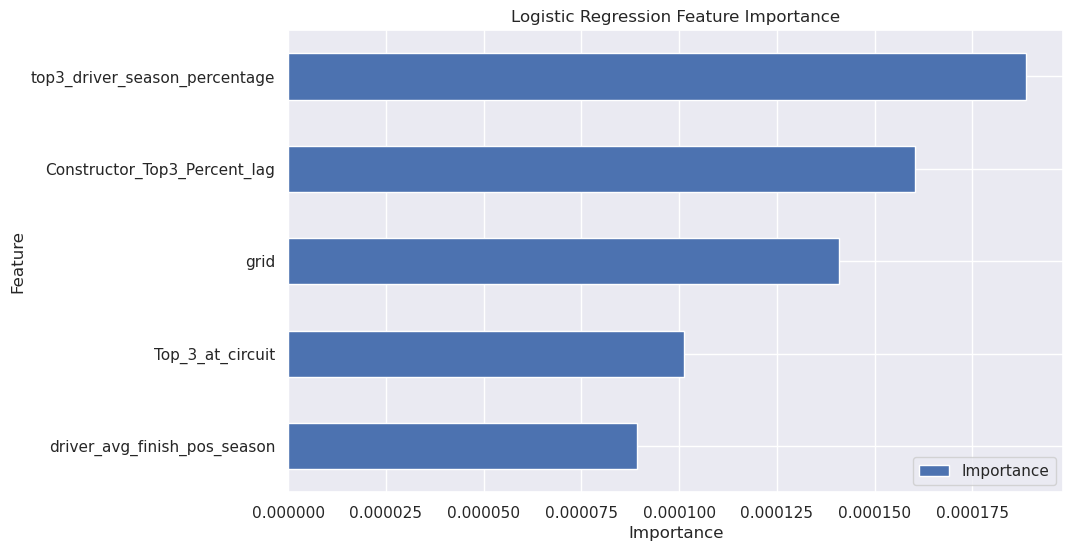

In [28]:
# Getting Feature importance from logistic regression
coefficients = best_lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train_std.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.savefig('Images/lrfeature_importance.png', bbox_inches='tight')

top3_driver_season_percentage is the most important for logistic regression, implying that the driver is also important

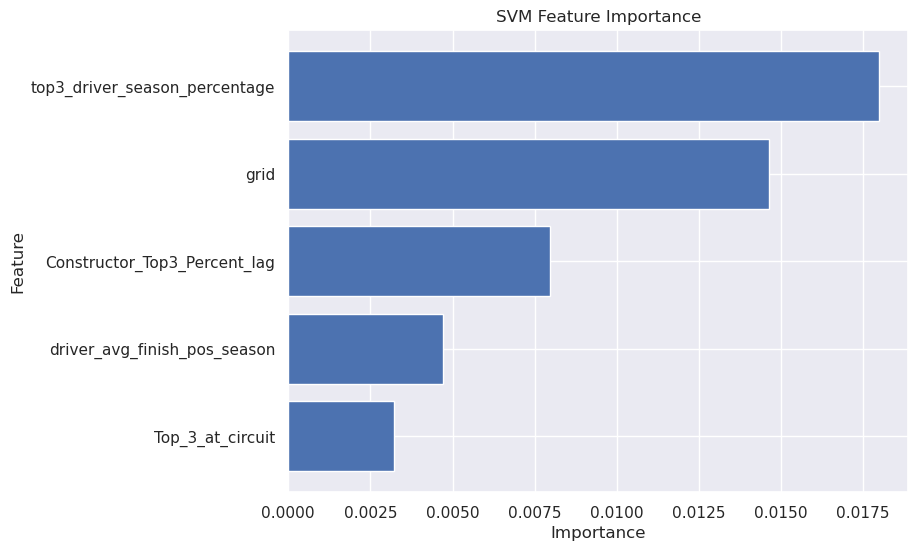

In [34]:
# SVC visualization
# Create the RFE object and rank each pixel
from sklearn.inspection import permutation_importance

results = permutation_importance(best_svc, X_train_std, y_train, scoring='accuracy', n_repeats=10, random_state=42)

# Get the mean importance scores and standard deviations
importances_mean = results.importances_mean
importances_std = results.importances_std
indices = np.argsort(importances_mean)[::-1]  # Sort by importance

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(len(importances_mean)), importances_mean[indices], color='b', align='center',)
plt.yticks(range(len(importances_mean)), [X_train_std.columns[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('SVM Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.savefig('Images/svcfeature_importance.png', bbox_inches='tight')
plt.show()

top3_driver_season_percentage is most important for SVC, providing evidence that driver is important